# Introduction

Hello Hiring Team,
In an attempt to make a good first impression I decided to simulate what I think is one of the task I will have to deal with in the Data Scientist position at **Montel**... **Price Forecasting of Nord Pool Energy Market**. In this simple model, I will attempt to predict the intraday Max Elbas Price. Identifying these moments could be valuable for traders, market participants, and energy providers, as it may present opportunities for strategic energy purchases and sales. However, given the simplicity of this model, it will not include any new information. This project in fact, serves as an initial approach to energy market price forecasting, rather than a real solution.

## Dataset Used for this Simulation
For this project I will use the "Nord Pool Energy Market Data" from Kaggle **[Link](https://www.kaggle.com/datasets/pythonafroz/nord-pool-energy-market-data?resource=download)**. While this dataset may not perfectly mirror Montel's operation, I still belive it can provide a valuable foundation for simulating real-world forecasting challenges!

Now, let’s dive in and load the dataset!

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import holidays


/Users/claudiogiannini/Desktop/Projects/sideproject_example/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version using kagglehub and add the file path to load the file
path = kagglehub.dataset_download("pythonafroz/nord-pool-energy-market-data")
file_path = os.path.join(path, "NordpoolMarket.csv")

# Quick check at the file location
print("Path to dataset files:", file_path)

# Load the dataframe
df = pd.read_csv(file_path, delimiter=';')

Path to dataset files: /Users/claudiogiannini/.cache/kagglehub/datasets/pythonafroz/nord-pool-energy-market-data/versions/2/NordpoolMarket.csv


# Exploring Our Dataframe

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99354 entries, 0 to 99353
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   HourUTC               99354 non-null  object
 1   HourDK                99354 non-null  object
 2   PriceArea             99354 non-null  object
 3   SpotPurchase          99354 non-null  object
 4   SpotSale              99354 non-null  object
 5   SpotPriceDKK          99354 non-null  object
 6   ElbasAveragePriceDKK  88398 non-null  object
 7   ElbasMaxPriceDKK      88398 non-null  object
 8   ElbasMinPriceDKK      88398 non-null  object
 9   SpotPriceEUR          99354 non-null  object
 10  ElbasAveragePriceEUR  88398 non-null  object
 11  ElbasMaxPriceEUR      88398 non-null  object
 12  ElbasMinPriceEUR      88398 non-null  object
dtypes: object(13)
memory usage: 9.9+ MB
None


There seem to be lots of missing values for the Elbas Market. Let's analyze a bit more carefully why. In addition to this they are all objects and this is a aannoying when working with dates and with what should be float numbers so let's fix both problems!

## Right Dtype for each column

In [4]:
df["HourUTC"] = pd.to_datetime(df["HourUTC"], errors="coerce")
df["HourDK"] = pd.to_datetime(df["HourDK"], errors="coerce")

numeric_cols = [
    "SpotPurchase", "SpotSale", "SpotPriceDKK", "ElbasAveragePriceDKK",
    "ElbasMaxPriceDKK", "ElbasMinPriceDKK", "SpotPriceEUR",
    "ElbasAveragePriceEUR", "ElbasMaxPriceEUR", "ElbasMinPriceEUR"
]

for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(",", ".").astype(float) # In our initial df the decimal point is a comma

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99354 entries, 0 to 99353
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   HourUTC               99354 non-null  datetime64[ns]
 1   HourDK                99354 non-null  datetime64[ns]
 2   PriceArea             99354 non-null  object        
 3   SpotPurchase          99354 non-null  float64       
 4   SpotSale              99354 non-null  float64       
 5   SpotPriceDKK          99354 non-null  float64       
 6   ElbasAveragePriceDKK  88398 non-null  float64       
 7   ElbasMaxPriceDKK      88398 non-null  float64       
 8   ElbasMinPriceDKK      88398 non-null  float64       
 9   SpotPriceEUR          99354 non-null  float64       
 10  ElbasAveragePriceEUR  88398 non-null  float64       
 11  ElbasMaxPriceEUR      88398 non-null  float64       
 12  ElbasMinPriceEUR      88398 non-null  float64       
dtypes: datetime64[ns

Great! Now this is fixed and will facilitate our analysis later on! Now let's look at how we decide to deal with missing values!

## Missing Values
We will first check if the NA values change over time

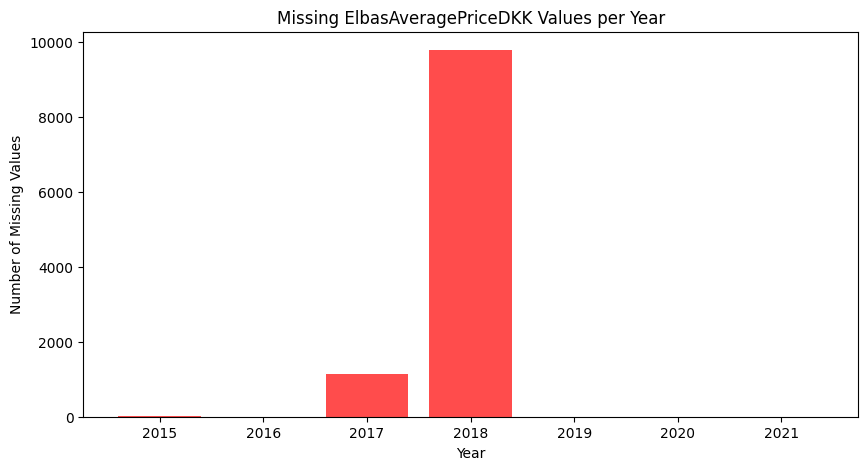

In [5]:
# Count missing values in ElbasAveragePriceDKK per year
df["Year"] = df["HourUTC"].dt.year
missing_values_per_year = df.groupby("Year")["ElbasAveragePriceDKK"].apply(lambda x: x.isnull().sum())

# Plot missing values per year
plt.figure(figsize=(10, 5))
plt.bar(missing_values_per_year.index, missing_values_per_year.values, color="red", alpha=0.7)
plt.xlabel("Year")
plt.ylabel("Number of Missing Values")
plt.title("Missing ElbasAveragePriceDKK Values per Year")
plt.xticks(missing_values_per_year.index)
plt.show()

Ok… weird. Something happened in the reporting between 2017 and 2018, which registered a big number of NAs in the Elbas market. I tried looking it up online, but I couldn’t find anything, and not knowing the reason why makes it difficult to find a way to properly handle it. If I had more context on what caused this spike—whether it was a regulatory change, a market shift, or a reporting issue—I could make a more informed decision on how to deal with these missing values. Without that information, I’d either have to impute the data blindly or exclude it altogether, which comes with its own risks. For now, I’ll proceed by focusing on 2019-2021, where the data is more complete and reliable.

In [6]:
df = df[df["HourUTC"].dt.year >= 2019]
missing_values = df.isnull().sum()
print(missing_values)

HourUTC                 0
HourDK                  0
PriceArea               0
SpotPurchase            0
SpotSale                0
SpotPriceDKK            0
ElbasAveragePriceDKK    3
ElbasMaxPriceDKK        3
ElbasMinPriceDKK        3
SpotPriceEUR            0
ElbasAveragePriceEUR    3
ElbasMaxPriceEUR        3
ElbasMinPriceEUR        3
Year                    0
dtype: int64


However, there are still a few remaining NaN values, which we will resolve using backward fill (bfill), ensuring that they are replaced with the next known valid observation.

In [7]:
df.fillna(method="bfill", inplace=True)
print(df.isnull().sum())  


HourUTC                 0
HourDK                  0
PriceArea               0
SpotPurchase            0
SpotSale                0
SpotPriceDKK            0
ElbasAveragePriceDKK    0
ElbasMaxPriceDKK        0
ElbasMinPriceDKK        0
SpotPriceEUR            0
ElbasAveragePriceEUR    0
ElbasMaxPriceEUR        0
ElbasMinPriceEUR        0
Year                    0
dtype: int64


/var/folders/z1/_f1dgn9d3vg65st2m_lw8_3c0000gn/T/ipykernel_50258/1370553782.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


# Data Engineering
Great so now that we will do some classic data engineering to help our future XGBoost model to capture important patterns in electricity prices like hour, day of week and month. Then also lag features like a 1 hour, 24 hour and a 1 week lag. Then we will also provide the df with a rolling window of the spot price for 3h and 24h adn lastly a boolean for Danish holiday that we will get thanks to the holiday library.

In [18]:
df["hour"] = df["HourUTC"].dt.hour
df["day_of_week"] = df["HourUTC"].dt.dayofweek
df["month"] = df["HourUTC"].dt.month

# Create Lag Features
df["lag_1"] = df["SpotPriceDKK"].shift(1)   # 1-hour lag
df["lag_24"] = df["SpotPriceDKK"].shift(24) # 24-hour lag
df["lag_168"] = df["SpotPriceDKK"].shift(168) # 1-week lag

# Create Rolling Mean Features
df["rolling_3h"] = df["SpotPriceDKK"].rolling(window=3, min_periods=1).mean()
df["rolling_24h"] = df["SpotPriceDKK"].rolling(window=24, min_periods=1).mean()

# Define the country (Denmark) and create a holiday feature (1 = holiday, 0 = normal day), plus get the day before and after the holiday
dk_holidays = holidays.Denmark()
df["is_holiday"] = df["HourUTC"].dt.date.astype(str).apply(lambda x: 1 if x in dk_holidays else 0)

df["is_day_before_holiday"] = df["HourUTC"].dt.date.astype(str).apply(
    lambda x: 1 if (pd.to_datetime(x) + pd.Timedelta(days=1)).strftime("%Y-%m-%d") in dk_holidays else 0
)

df["is_day_after_holiday"] = df["HourUTC"].dt.date.astype(str).apply(
    lambda x: 1 if (pd.to_datetime(x) - pd.Timedelta(days=1)).strftime("%Y-%m-%d") in dk_holidays else 0
)

df["is_holiday"].unique()

array([1, 0])

## Data Visualization of New DataFrame
This boxplot illustrates the distribution of Spot Price (DKK) across different hours of the day. We observe a clear daily pattern, with prices generally lower during nighttime (00:00 - 06:00) when demand is low and peaking in the late afternoon and evening (16:00 - 20:00) due to increased energy consumption. Additionally, there are significant outliers, indicating occasional price spikes, possibly driven by demand fluctuations.


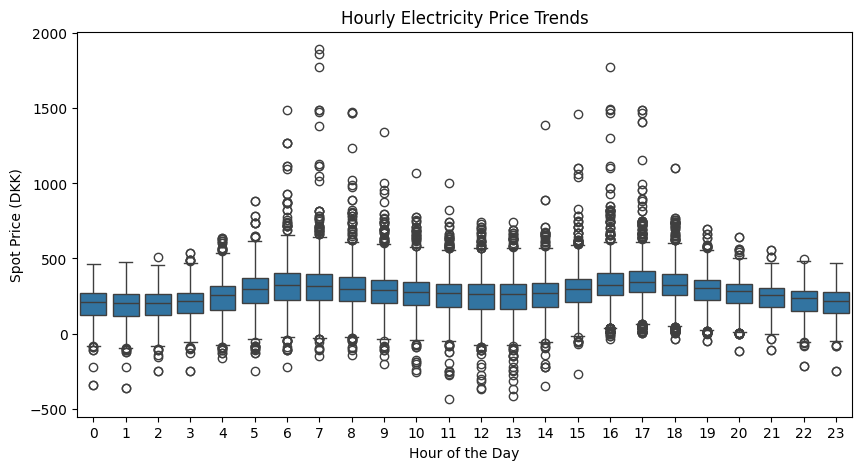

In [9]:
# Average price by hour
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["hour"], y=df["SpotPriceDKK"])
plt.xlabel("Hour of the Day")
plt.ylabel("Spot Price (DKK)")
plt.title("Hourly Electricity Price Trends")
plt.show()


Prices appear relatively stable throughout the week, with no significant variations between weekdays and weekends. However, there are numerous outliers, indicating occasional price spikes, particularly on weekdays.


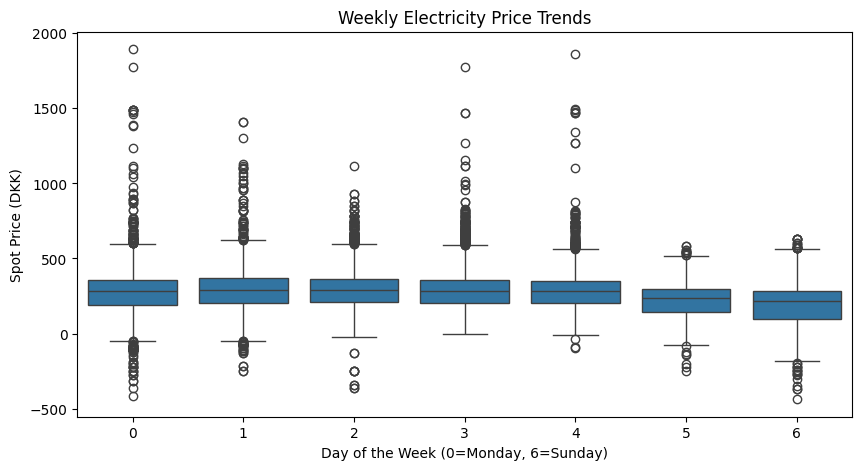

In [10]:
# Average price by day of the week
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["day_of_week"], y=df["SpotPriceDKK"])
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Spot Price (DKK)")
plt.title("Weekly Electricity Price Trends")
plt.show()

# Model Training
## Benchmark Model
As a benchmark model we will use the Naïve Forecast which simply copies the last observed value as the prediction.


In [11]:
# Define features and target
features = ["hour", "day_of_week", "lag_1", "lag_24", "lag_168", "rolling_3h", "rolling_24h", "is_holiday", "is_day_before_holiday", "is_day_after_holiday"]
target = "ElbasMaxPriceDKK"

X = df[features]
y = df[target]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [12]:
baseline_mae = mean_absolute_error(y_test, X_test["lag_1"])
baseline_rmse = np.sqrt(mean_squared_error(y_test, X_test["lag_1"]))

# Print results
print(f"Baseline MAE (Using lag_1): {baseline_mae:.2f}")
print(f"Baseline RMSE (Using lag_1): {baseline_rmse:.2f}")


Baseline MAE (Using lag_1): 49.85
Baseline RMSE (Using lag_1): 87.69


## Our Model

We train our model using the feautres we obtaines in the data engineering section. 

Mean Absolute Error (MAE): 47.45
Root Mean Squared Error (RMSE): 78.94


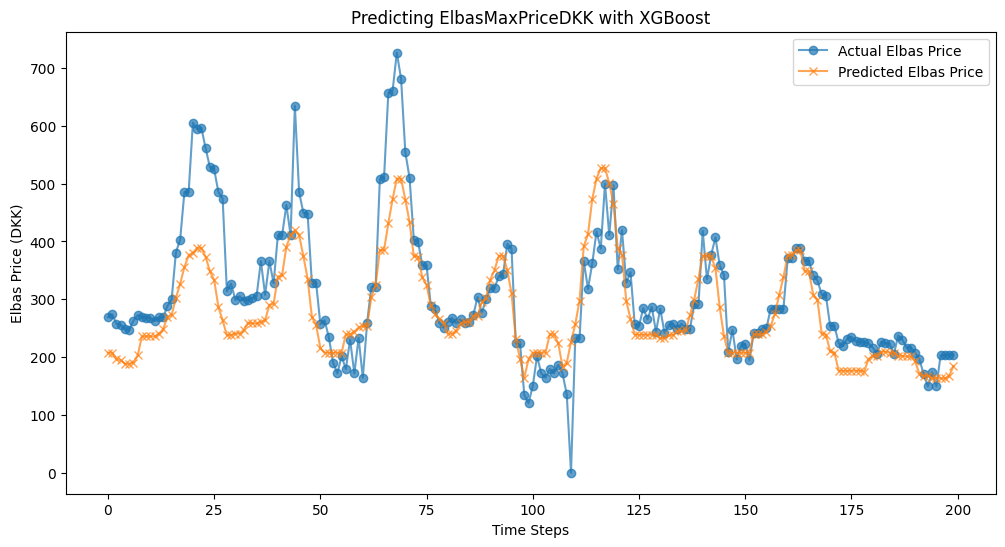

In [17]:
# Define features and target
features = ["hour", "day_of_week", "lag_1", "lag_24", "lag_168", "rolling_3h", "rolling_24h", "is_holiday", "is_day_before_holiday", "is_day_after_holiday"]
target = "ElbasMaxPriceDKK"

X = df[features]
y = df[target]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train XGBoost Regressor
model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.01, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot Actual vs. Predicted Elbas Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:200], label="Actual Elbas Price", marker="o", alpha=0.7)
plt.plot(y_pred[:200], label="Predicted Elbas Price", marker="x", alpha=0.7)
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Elbas Price (DKK)")
plt.title("Predicting ElbasMaxPriceDKK with XGBoost")
plt.show()

he XGBoost model demonstrates an improvement over the baseline lag_1 model in predicting ElbasMaxPriceDKK. With a Mean Absolute Error (MAE) of 47.45 compared to 49.85 in the baseline, the model achieves a lower average prediction error. Additionally, the Root Mean Squared Error (RMSE) is reduced to 78.94, compared to 87.69 for the baseline, indicating that the model handles larger deviations better.

The visualization shows that while the model successfully captures overall trends, it still struggles with sharp price spikes, **suggesting that further feature engineering or alternative modeling approaches may enhance performance**
